# Car Prediction Model (linear regression) 

## Read Data

In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

## Data Preparation

In [16]:
def data_prep(column):
    return column.str.lower().str.replace(' ', '_')

df.columns = data_prep(df.columns)

for col in list(df.dtypes[df.dtypes == 'object'].index):
    df[col] = data_prep(df[col])

## Exploratory data analysis

<AxesSubplot:xlabel='msrp', ylabel='Count'>

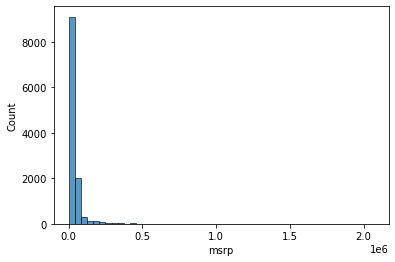

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.histplot(df.msrp, bins=50)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

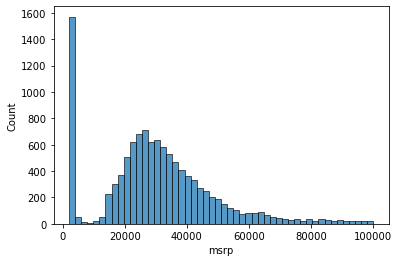

In [18]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

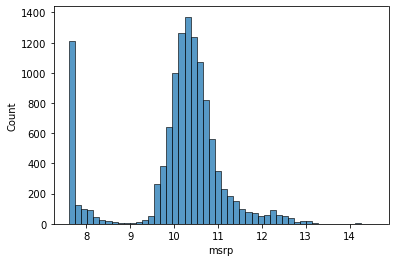

In [20]:
price_logs = np.log1p(df.msrp)
sns.histplot(price_logs, bins=50)

## Setting up the validation framework

In [40]:
'''split dataset index'''
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

'''shuffle dataset index'''
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)
idx[0]

'''split dataset'''
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

'''reset index in dataset'''
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

'''save target column "msrp" in log form'''
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

'''remove target column from dataset'''
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']



7150

## Linear regression for car price baseline model

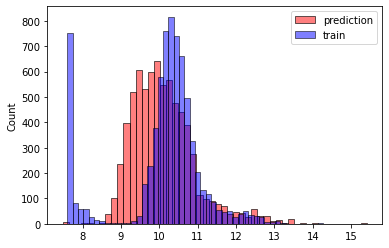

In [56]:
# '''Linear regression'''
# def linear_regression(X):
#     return X.dot(w_new)

# '''Linear regression vector form'''
# def dot(xi, w):
#     n = len(xi)
    
#     res = 0.0
    
#     for j in range(n):
#         res = res + xi[j] * w[j]
    
#     return res


def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

'''define base for training'''
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']
X_train = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

'''diagram'''
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_train, label='train', color='blue', alpha=0.5, bins=50)
plt.legend()


## RMSE

In [46]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

rmse(y_train, y_pred)

0.7554192603920132

## Validating the model

In [47]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.7616530991301601

## Simple feature engineering

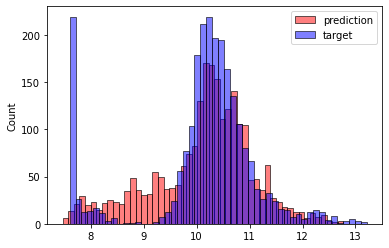

In [49]:
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

## Categorical variables

In [57]:
'''non-number values added into model'''
categorical_columns = [
    'make', 'model', 'engine_fuel_type', 'driven_wheels', 'market_category',
    'vehicle_size', 'vehicle_style']

categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head().index)
    
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']

    for v in [2, 3, 4]:
        df['num_doors_%d' % v] = (df.number_of_doors == v).astype(int)
        features.append('num_doors_%d' % v)

    for name, values in categorical.items():
        for value in values:
            df['%s_%s' % (name, value)] = (df[name] == value).astype(int)
            features.append('%s_%s' % (name, value))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X    
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)
w0, w

(-1892716650172707.5,
 array([-1.25979400e-01, -4.11769415e+00, -1.49135423e+00, -1.20091264e+00,
        -1.87328446e-03, -1.15204727e+00, -1.38350480e+03, -1.39334362e+03,
        -1.39351243e+03,  9.15554192e-01,  2.06949015e+00, -3.70946478e+00,
        -3.60208641e+01, -7.60809203e-01,  6.99211474e+00,  4.21527311e+01,
         9.08207080e+00,  3.58850527e+00,  2.21686135e+02, -2.79986339e+01,
        -1.66096998e+01, -1.53650629e+01, -3.19971147e+01, -2.92630679e+01,
         1.89271665e+15,  1.89271665e+15,  1.89271665e+15,  1.89271665e+15,
        -8.15147229e-01, -3.70773744e+00, -9.46407895e+00, -9.25611606e+00,
        -2.25503056e+00, -3.23997652e+01, -2.13494836e+01, -9.63406803e+00,
        -1.44115660e-01, -2.62579827e-02,  1.75913981e-01,  3.65037816e-01,
        -2.90235596e-01]))

## Regularization

In [59]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.46082082859744394

## Tuning the model

In [61]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)
    
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

0.0 -1892716650172707.5 25.292847981509013
1e-05 3.6115197670511923 0.4608153253290002
0.0001 7.140222414403334 0.46081536380153515
0.001 7.1308371443539045 0.46081585831091265
0.1 7.000232393487698 0.460873654912963
1 6.250747847474107 0.46158128382747665
10 4.729512585699661 0.4726098772668167


0.46081585831091265

## Using the model

In [62]:
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
X_full_train = prepare_X(df_full_train)
X_full_train

array([[148.,   4.,  33., ...,   1.,   0.,   0.],
       [132.,   4.,  32., ...,   0.,   0.,   1.],
       [148.,   4.,  37., ...,   0.,   0.,   1.],
       ...,
       [332.,   8.,  23., ...,   0.,   0.,   0.],
       [148.,   4.,  34., ...,   0.,   0.,   0.],
       [290.,   6.,  25., ...,   0.,   0.,   0.]])

In [64]:
y_full_train = np.concatenate([y_train, y_val])
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.46007539689131327

In [65]:
car = df_test.iloc[20].to_dict()
car

{'make': 'toyota',
 'model': 'sienna',
 'year': 2015,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 266.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'large',
 'vehicle_style': 'passenger_minivan',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

In [68]:
df_small = pd.DataFrame([car])
X_small = prepare_X(df_small)
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

10.63249250859538

In [69]:
np.expm1(y_pred)

41459.33676459627

In [70]:
np.expm1(y_test[20])

35000.00000000001